# Part 0 and the Packages used

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

data_gen = ImageDataGenerator(rescale=1.0/255)

Using TensorFlow backend.


In [2]:
imgdir = 'a5_images'
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [3]:
Xbatch, Ybatch = train_generator.next()

In [4]:
from matplotlib import pyplot as plt
plt.style.use('bmh')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

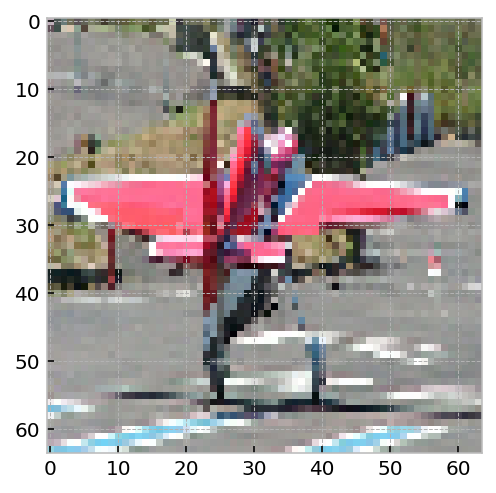

In [5]:
plt.imshow(Xbatch[0]);

# Part 1 - Making the Convolutional network

In [6]:
Xbatch = Xbatch.reshape(Xbatch.shape[0], img_size, img_size, 3)

def make_convnet(img_width, img_height, c):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
    
cnn = make_convnet(img_size, img_size, 3)    

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        shuffle=True)

Found 576 images belonging to 2 classes.


The trainingBatchSize and validationBatchSize are created here so that we ensure that we use the entire set and don't miss out on parts of the set.

In [8]:
trainingBatchSize = math.ceil( 1600 / batch_size)
validationBatchSize = math.ceil( 576 / batch_size)
history = cnn.fit_generator(train_generator, 
                  validation_data=validation_generator, 
                  steps_per_epoch=trainingBatchSize,
                  validation_steps=validationBatchSize,
                  epochs=10,
                  use_multiprocessing=False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
50/50 [==============================] - 22s 436ms/step - loss: 0.6916 - acc: 0.5769 - val_loss: 0.6418 - val_acc: 0.6493
Epoch 2/10
50/50 [==============================] - 20s 403ms/step - loss: 0.5978 - acc: 0.6981 - val_loss: 0.5696 - val_acc: 0.7292
Epoch 3/10
50/50 [==============================] - 20s 393ms/step - loss: 0.5153 - acc: 0.7600 - val_loss: 0.6461 - val_acc: 0.6892
Epoch 4/10
50/50 [==============================] - 20s 401ms/step - loss: 0.4626 - acc: 0.7850 - val_loss: 0.5046 - val_acc: 0.7760
Epoch 5/10
50/50 [==============================] - 20s 400ms/step - loss: 0.4321 - acc: 0.8056 - val_loss: 0.5268 - val_acc: 0.7656
Epoch 6/10
50/50 [==============================] - 20s 401ms/step - loss: 0.3717 - acc: 0.8363 - val_loss: 0.5052 - val_acc: 0.7934
Epoch 7/10
50/50 [==============================] - 20s 406ms/step - loss: 0.3112 - acc: 0.8662 - val_loss: 0.5447 - val_acc: 0.7743
Epoch 8/10
50/50 [===

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


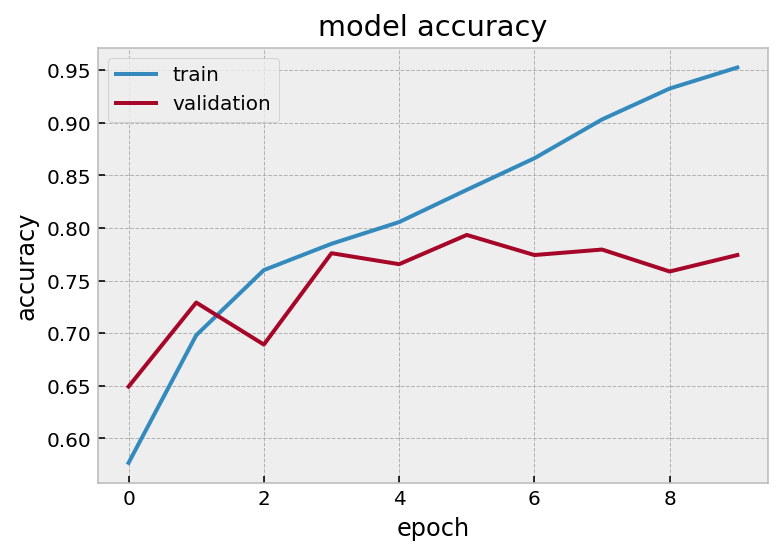

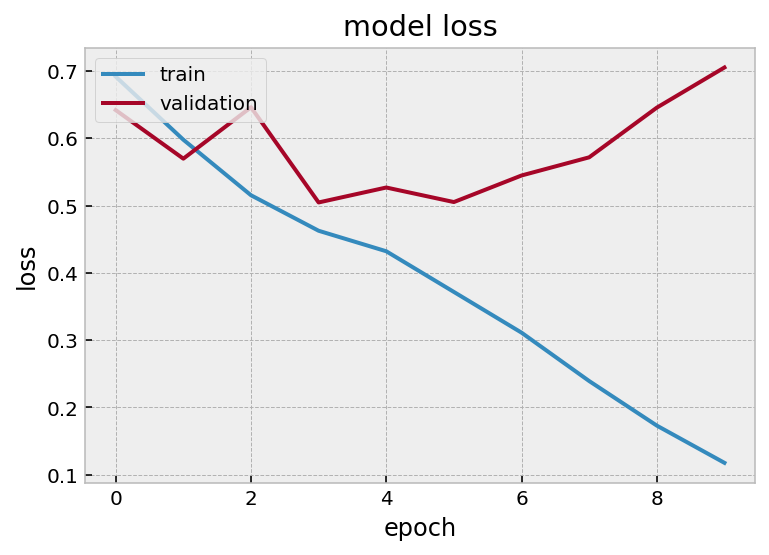

In [9]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Here we see a large amount of overfitting. The accuracy of the model increases continuously for the test set however the accuarcy for the validation set seems to improve at first but then decrease again. We could have implemented early stopping however we wanted to see how the accuracy changes as the model overfits.

# Part 3 - VGG16

[[('n03594945', 'jeep', 0.92140627),
  ('n04252225', 'snowplow', 0.0243272),
  ('n03445924', 'golfcart', 0.014407205),
  ('n03930630', 'pickup', 0.012664951),
  ('n03478589', 'half_track', 0.005270824)]]

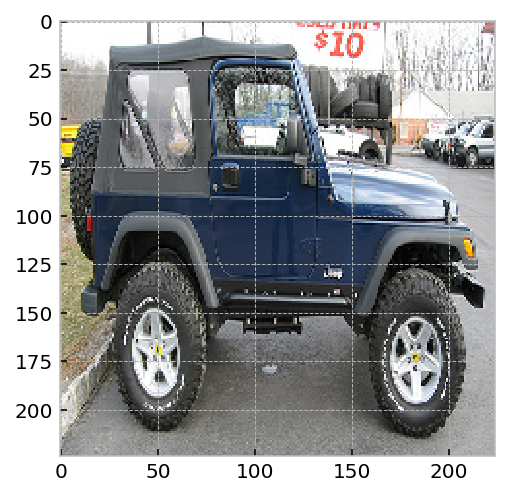

In [10]:
from keras import applications
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

vggmodel = applications.VGG16(weights='imagenet', include_top=True)
img = load_img('a5_images/validation/car/0000.jpg', target_size=(224,224))
plt.imshow(img);
imgArray = img_to_array(img)
imgVGG = preprocess_input(imgArray)
imgVGG = imgVGG.reshape(1, 224, 224, 3)
decode_predictions(vggmodel.predict(imgVGG))

The prediciton is that the image is of a jeep with 92.1 % certainty which indeed makes sense. It does look like the image depicts a jeep so the network does seem to have made an accurate prediction. There are some more possibilities given by the network namely snowplow, golf cart and pickup which are also types of cars.

In [11]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_vgg16_features(subdir):
    generator = vgg_data_gen.flow_from_directory(
        imgdir + '/' + subdir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False)
    if subdir == 'train' : step_size = 1600/batch_size
    else : step_size = 576/batch_size
    cnn_features = feature_extractor.predict_generator(generator, steps=step_size, verbose=1)
    with open('vgg16_' + subdir, 'wb') as f:
       np.save(f, cnn_features)

create_vgg16_features('train')
create_vgg16_features('validation')


Found 1600 images belonging to 2 classes.
50/50 [==============================] - 71s 1s/step
Found 576 images belonging to 2 classes.
18/18 [==============================] - 26s 1s/step


In [12]:
def make_vggnet():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model  

def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))    

def train_on_cnnfeatures():
    with open('vgg16_train', 'rb') as f:
        train_data = np.load(f)
    with open('vgg16_validation', 'rb') as f:
        val_data = np.load(f)
    vggmodel = make_vggnet()    
    history  = vggmodel.fit(x=train_data, 
                            y=get_labels(1600), 
                            epochs=10, 
                            validation_data=[val_data, get_labels(576)],
                            steps_per_epoch=32, 
                            validation_steps=32)
    return history, vggmodel

In [13]:
history, model = train_on_cnnfeatures()

Train on 1600 samples, validate on 576 samples
Epoch 1/10
32/32 [==============================] - 2s 68ms/step - loss: 0.5386 - acc: 0.9498 - val_loss: 1.2565 - val_acc: 0.8750
Epoch 2/10
32/32 [==============================] - 1s 47ms/step - loss: 0.2368 - acc: 0.9851 - val_loss: 1.1948 - val_acc: 0.8889
Epoch 3/10
32/32 [==============================] - 1s 47ms/step - loss: 0.1991 - acc: 0.9875 - val_loss: 1.1237 - val_acc: 0.8958
Epoch 4/10
32/32 [==============================] - 1s 46ms/step - loss: 0.1699 - acc: 0.9894 - val_loss: 1.1332 - val_acc: 0.8906
Epoch 5/10
32/32 [==============================] - 1s 47ms/step - loss: 0.1697 - acc: 0.9894 - val_loss: 1.1335 - val_acc: 0.8906
Epoch 6/10
32/32 [==============================] - 1s 46ms/step - loss: 0.1697 - acc: 0.9894 - val_loss: 1.1329 - val_acc: 0.8906
Epoch 7/10
32/32 [==============================] - 1s 45ms/step - loss: 0.1697 - acc: 0.9894 - val_loss: 1.1335 - val_acc: 0.8906
Epoch 8/10
32/32 [==================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


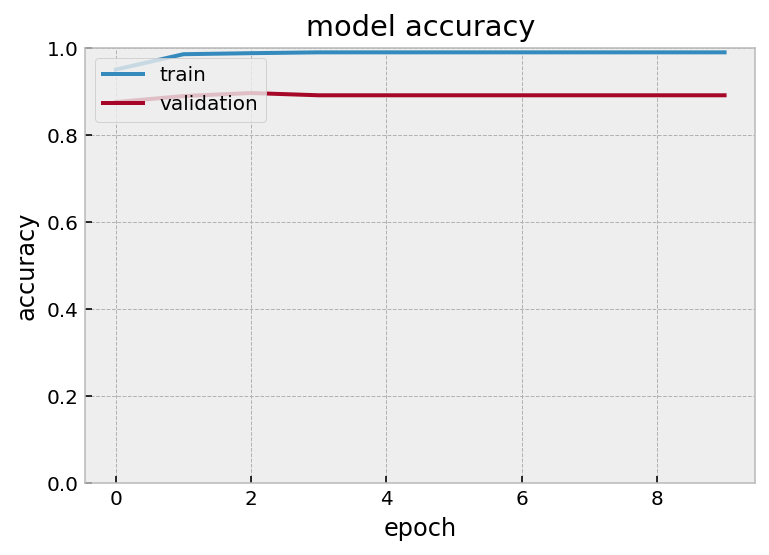

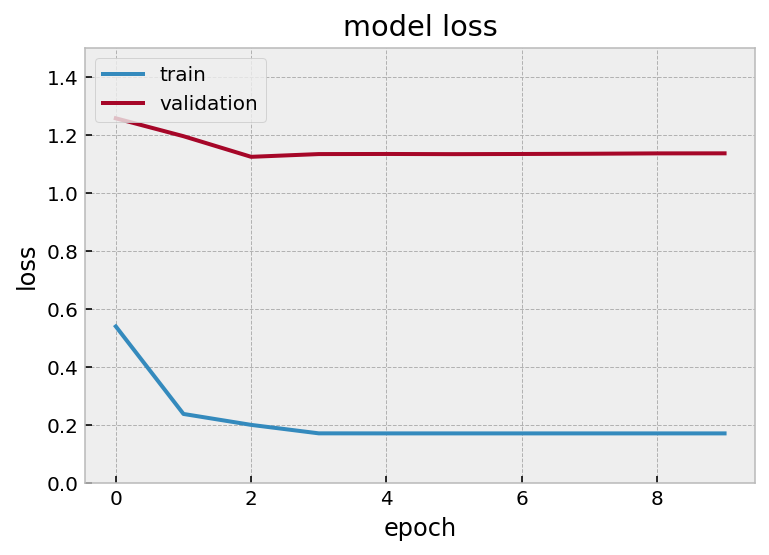

In [14]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0,1.5)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Here we see far better results than we did for our own convolutional network. We also see less overfitting although it is still prevalent. Our small training set probably doesn't allow the neural network to learn enough about how to classify the images. By utilizing vgg16 to generate features we could use several algorithms for the classifier. Here we used a neural network for the classifier simply because we could reuse code. However, it is possible that another algorithm such as SGD would have performed better.

# Part 4 - Visualizing the features

Here we first visualize three parts of the weights for the first layer. The last image is the entire for layer visualied as we were curious to see how it looked in its entirety.

In [15]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k



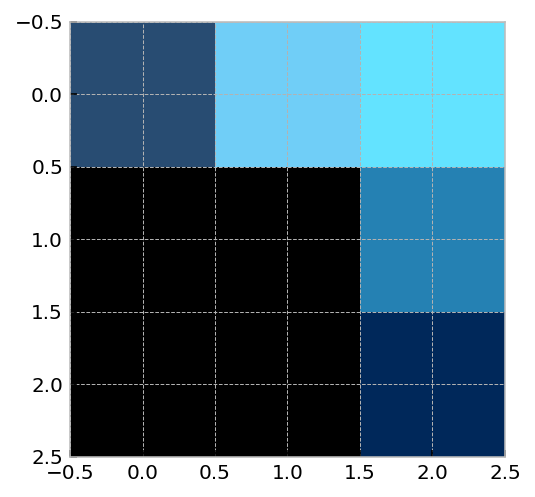

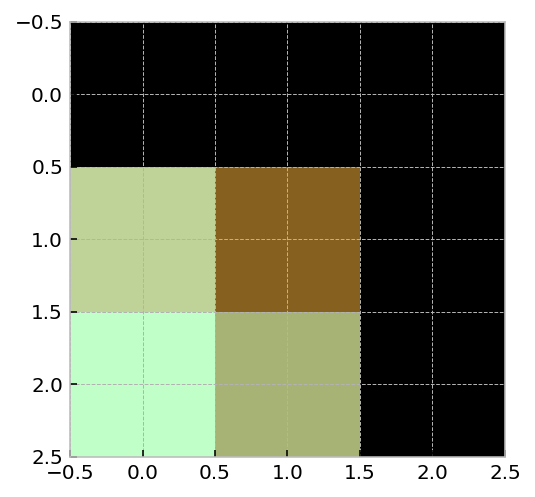

In [16]:
plt.imshow(kernel_image(vggmodel.get_weights()[0], 7, True))
plt.show()
plt.imshow(kernel_image(vggmodel.get_weights()[0], 7, False))
plt.show()

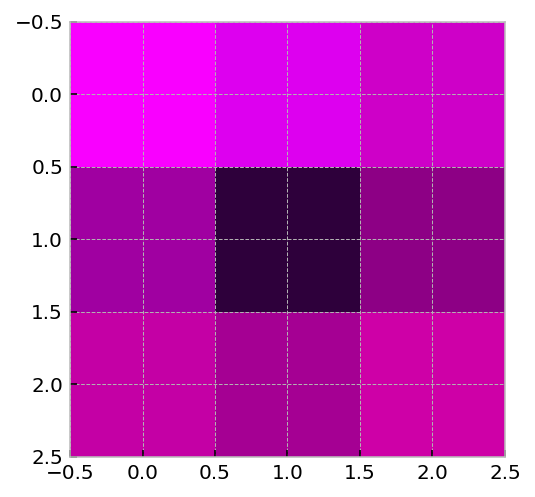

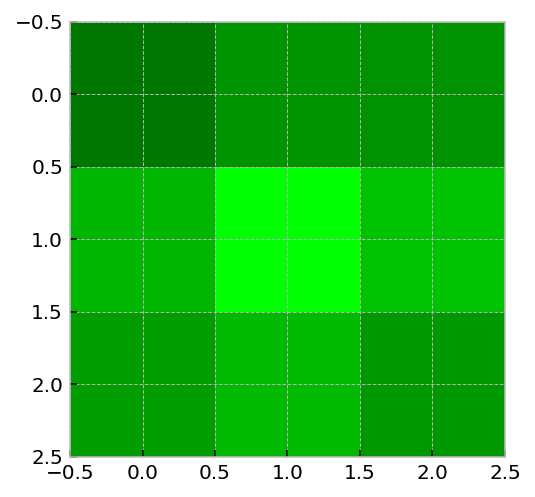

In [17]:
plt.imshow(kernel_image(vggmodel.get_weights()[0], 15, True))
plt.show()
plt.imshow(kernel_image(vggmodel.get_weights()[0], 15, False))
plt.show()

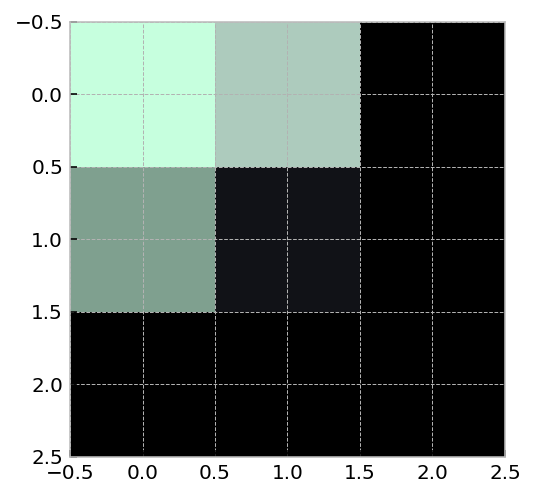

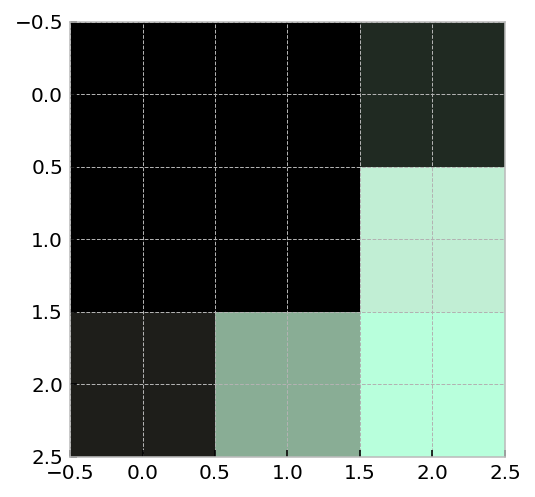

In [18]:
plt.imshow(kernel_image(vggmodel.get_weights()[0], 0, True))
plt.show()
plt.imshow(kernel_image(vggmodel.get_weights()[0], 0, False))
plt.show()

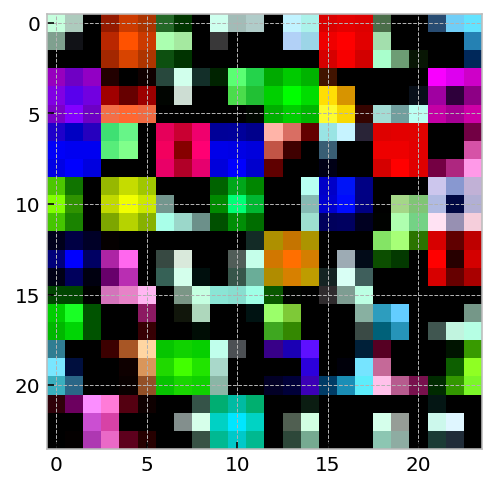

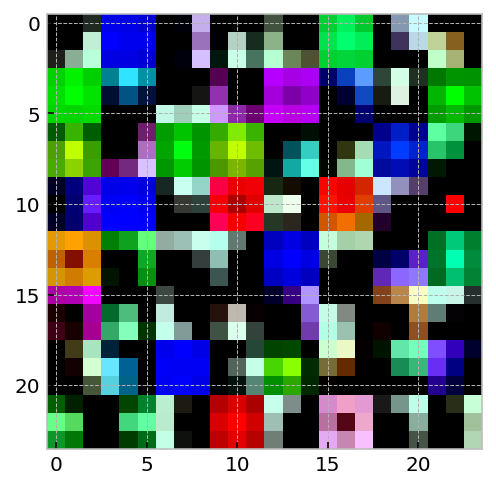

In [19]:
def ShowWholeFilter(b): 
    A = np.empty((3,3,3))
    for j in range(8):
        B = kernel_image(vggmodel.get_weights()[0], j*8, b)
        for i in range(7):
            B = np.hstack((B, kernel_image(vggmodel.get_weights()[0], j*8 + (i+1), b)))
        if j == 0:
            A = B
        else:
            A= np.vstack((A,B))
        if(j == 7):
            return A
plt.imshow(ShowWholeFilter(True))     
plt.show()
plt.imshow(ShowWholeFilter(False))     
plt.show()
